<a href="https://colab.research.google.com/github/google/jax-md/blob/simulation_refactor_2/notebooks/npt_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports & Utils

!pip install jax-md

import numpy as onp

from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax
from jax import ops

import time

from jax_md import space, smap, energy, minimize, quantity, simulate

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Constant Pressure Simulation

Here we demonstrate some code to run a simulation at in the NPT ensemble with constant temperature and pressure. We start off by setting up some parameters of the simulation. This will include a pressure schedule that will start off at a relatively low pressure before instantaneously trippling the pressure. 

Note that unlike in the case of NVT and NVE simulations, NPT simulations must be performed with `periodic_general` boundary conditions. For now NPT simulations must be performed with fractional coordinates, where the atom positions are stored in the unit cube. This restriction can likely be relaxed in the future, if it were desirable.

In [2]:
N = 400
dimension = 2
box = quantity.box_size_at_number_density(N, 0.8, 2)
dt = 5e-3
displacement, shift = space.periodic_general(box) 

kT = np.float32(0.01)
P = lambda t: np.where(t < 100.0, 0.05, 0.15)

Next we need to generate some random positions as well as particle sizes. Because we are using `periodic_general` boundary conditions with fractional coordinates, we produce initial particle positions in the unit cube.

In [3]:
key = random.PRNGKey(0)

In [4]:
key, split = random.split(key)
R = random.uniform(split, (N, dimension), dtype=np.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = np.where(np.arange(N) < N_2, 0, 1)

Then we need to construct our simulation operators.

In [5]:
energy_fn = energy.soft_sphere_pair(displacement, species=species, sigma=sigma)

init, apply = simulate.npt_nose_hoover(energy_fn, shift, dt, P(0.), kT)
state = init(key, R, box)

Now let's actually do the simulation. To do this we'll write a small function that performs a single step of the simulation. This function will keep track of the temperature, the extended Hamiltonian of the Nose-Hoover dynamics, and the current particle positions.

In [6]:
write_every = 100

def step_fn(i, state_and_log):
  state, log = state_and_log

  t = i * dt

  # Log information about the simulation.
  T = quantity.temperature(state.velocity)
  log['kT'] = ops.index_update(log['kT'], i, T)

  box = simulate.npt_box(state)
  KE = quantity.kinetic_energy(state.velocity)
  P_measured = quantity.pressure(energy_fn, state.position, box, KE)
  log['P'] = ops.index_update(log['P'], i, P_measured)

  H = simulate.npt_nose_hoover_invariant(energy_fn, state, P(t), kT)
  log['H'] = ops.index_update(log['H'], i, H)
  
  # Record positions every `write_every` steps.
  pos = space.transform(box, state.position)
  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: ops.index_update(p, 
                                                        i // write_every, 
                                                        pos),
                             lambda p: p,
                             log['position'])

  # Take a simulation step.
  state = apply(state, pressure=P(t))
  
  return state, log

To run our simulation we'll use `lax.fori_loop` which will execute the simulation a single call from python.

In [7]:
steps = 40000

log = {
    'kT': np.zeros((steps,)),
    'P': np.zeros((steps,)),
    'H': np.zeros((steps,)),
    'position': np.zeros((steps // write_every,) + R.shape) 
}

state, log = lax.fori_loop(0, steps, step_fn, (state, log))

Now, let's plot the temperature, pressure, and hamiltonian as a function of time. We see that the temperature and pressure track the target with some fluctuations. The Hamiltonian is exactly invariant apart from the point where the target pressure is changed discontinuously.

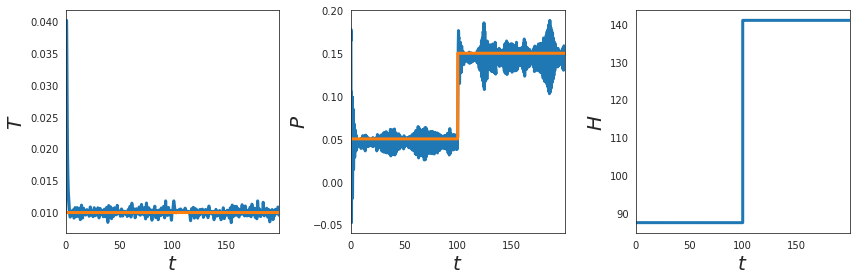

In [8]:
plt.subplot(1, 3, 1)

t = onp.arange(0, steps) * dt
plt.plot(t, log['kT'], linewidth=3)
plt.plot(t, kT * np.ones_like(t), linewidth=3)
plt.xlim([t[0], t[-1]])
format_plot('$t$', '$T$')

plt.subplot(1, 3, 2)

t = onp.arange(0, steps) * dt
plt.plot(t, log['P'], linewidth=3)
plt.plot(t, P(t), linewidth=3)
plt.xlim([t[0], t[-1]])
format_plot('$t$', '$P$')

plt.subplot(1, 3, 3)

t = onp.arange(0, steps) * dt
plt.plot(t, log['H'], linewidth=3)
plt.xlim([t[0], t[-1]])
format_plot('$t$', '$H$')

finalize_plot((2, 2 / 3))

Now let's plot a snapshot of the system.

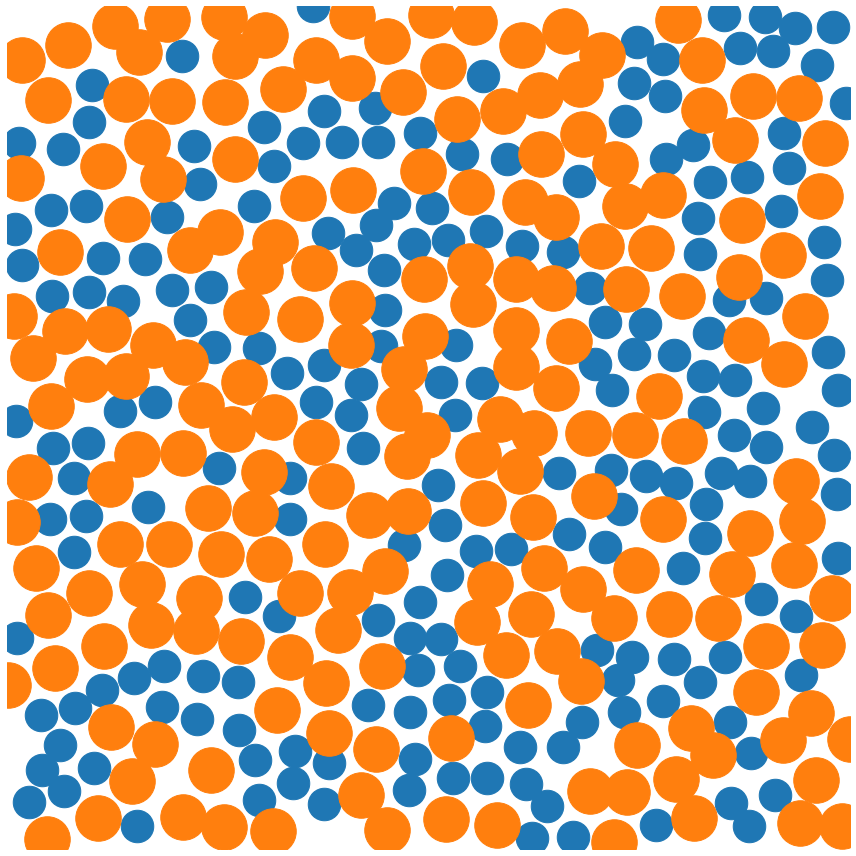

In [9]:
ms = 65
R_plt = onp.array(log['position'][-1])

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, np.max(R_plt[:, 0])])
plt.ylim([0, np.max(R_plt[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

If we want, we can also draw an animation of the simulation using JAX MD's renderer. We see that the system starts out fluctuating about an initial larger box. When the pressure instantaneously changes, the box compresses the system.

In [10]:
from jax_md.colab_tools import renderer

diameters = sigma[species, species]
colors = np.where(species[:, None], 
                  np.array([[1.0, 0.5, 0.01]]), 
                  np.array([[0.35, 0.65, 0.85]]))

renderer.render(box,
                {
                    'particles': renderer.Disk(log['position'], 
                                               diameters,
                                               colors)
                },
                resolution=(700, 700))

## Larger Simulation with Neighbor Lists

##### **Warning: This section is a work in progress. We hope to make NPT + neighbor lists more ergonimic and safe in the future.**

We can use neighbor lists to run a much larger version of this simulation. As their name suggests, neighbor lists are lists of particles nearby a central particle. By keeping track of neighbors, we can compute the energy of the system much more efficiently. This becomes increasingly true as the simulation gets larger. Unlike other simulation environments, extra care must be taken with NPT simulations when using cell lists to construct neighbor lists (which is the default behavior). This is because the cells must be defined in the unit cube. As the system's volume changes, the effective size of cells will change. At some point, this may invalidate cell list, either because of buffer overflows or because the cells become too small to cover the desired neighborhood size. While we have error checking in the former case, we do not yet have checks for the latter. 

The code in this section therefore is to serve as an example for how neighbor lists + NPT might work. We expect to improve this section with time. If it is a priority for your work, please raise an issue.

As before, the first step here is to setup some simulation parameters. Unlike before, here we must be especially mindful of fluctuations in the box size. As such we will start out by creating the system and randomly initializing it. However, we will then minimize the system to its nearest minimum before starting the simulation.

In [25]:
N = 10000
dt = 5e-3
box = quantity.box_size_at_number_density(N, 0.8, 2) * np.eye(2)
displacement, shift = space.periodic_general(box) 

kT = np.float32(0.01)
P = lambda t: np.where(t < 100.0, 0.05, 0.07)

As before we randomly initialize the system.

In [26]:
key, split = random.split(key)
R = random.uniform(split, (N, dimension), dtype=np.float64)

sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = np.where(np.arange(N) < N_2, 0, 1)

Then we need to construct our simulation operators. This time we use the `energy.soft_sphere_neighbor_fn` to create two functions: one that constructs lists of neighbors and one that computes the energy. Since we store the particle positions fractionally (in the unit cube), we must pass `fractional_coordinates=True` to the energy function.

In [27]:
neighbor_fn, energy_fn = energy.soft_sphere_neighbor_list(
    displacement, box, species=species, sigma=sigma, fractional_coordinates=True)

init, apply = minimize.fire_descent(energy_fn, shift)

nbrs = neighbor_fn(R)

state = init(R, neighbor=nbrs)

def cond_fn(state_nbrs):
  state, nbrs = state_nbrs
  return np.any(np.abs(state.force) > 1e-3)

def step_fn(state_nbrs):
  state, nbrs = state_nbrs
  state = apply(state, neighbor=nbrs)
  nbrs = neighbor_fn(state.position, nbrs)
  return state, nbrs

state, nbrs = lax.while_loop(cond_fn, step_fn, (state, nbrs))

print(f'Did buffer overflow: {nbrs.did_buffer_overflow}')
print(f'Pressure: {quantity.pressure(energy_fn, state.position, box, neighbor=nbrs)}')

Did buffer overflow: False
Pressure: 0.03150192145142338


Now we can plot the minimized configuration.

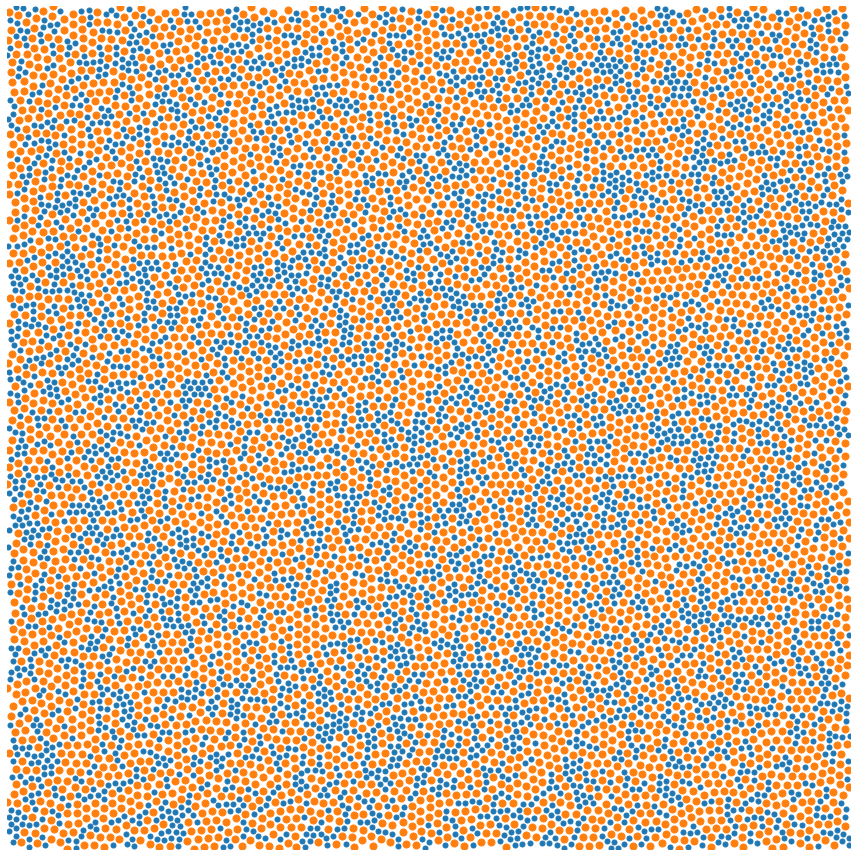

In [28]:
ms = 10
R_plt = onp.array(state.position)

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

Now that we have a minimized configuration, we can do an NPT simulation. Since our cells have a fixed size, the neighbor list that we constructed will become invalid if the box is too small.

In [30]:
init, apply = simulate.npt_nose_hoover(energy_fn, shift, dt, P(0.), kT)

nbrs = neighbor_fn(state.position, extra_capacity=35)
state = init(key, state.position, box, neighbor=nbrs)

Now let's actually do the simulation. This time our simulation step function will also update the neighbors. As above, we will also only record position data every hundred steps.

In [31]:
write_every = 100

def step_fn(i, state_nbrs_log):
  state, nbrs, log = state_nbrs_log

  t = i * dt

  # Log information about the simulation.
  T = quantity.temperature(state.velocity)
  log['kT'] = ops.index_update(log['kT'], i, T)

  box = simulate.npt_box(state)
  KE = quantity.kinetic_energy(state.velocity)
  P_measured = quantity.pressure(energy_fn, state.position, box, KE, neighbor=nbrs)
  log['P'] = ops.index_update(log['P'], i, P_measured)

  H = simulate.npt_nose_hoover_invariant(energy_fn, state, P(t), kT, neighbor=nbrs)
  log['H'] = ops.index_update(log['H'], i, H)
  
  # Record positions every `write_every` steps.
  pos = space.transform(box, state.position)
  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: ops.index_update(p, 
                                                        i // write_every, 
                                                        pos),
                             lambda p: p,
                             log['position'])

  # Take a simulation step.
  state = apply(state, neighbor=nbrs, pressure=P(t))
  box = simulate.npt_box(state)
  nbrs = neighbor_fn(state.position, nbrs, box=box)
  
  return state, nbrs, log

To run our simulation we'll use `lax.fori_loop` which will execute the simulation a single call from python.

In [32]:
steps = 40000

log = {
    'P': np.zeros((steps,)),
    'kT': np.zeros((steps,)),
    'H': np.zeros((steps,)),
    'position': np.zeros((steps // write_every,) + R.shape) 
}

state, nbrs, log = lax.fori_loop(0, steps, step_fn, (state, nbrs, log))

print(nbrs.did_buffer_overflow)

R = state.position

False


Now, let's plot the temperature as a function of time. We see that the temperature tracks the goal temperature with some fluctuations.

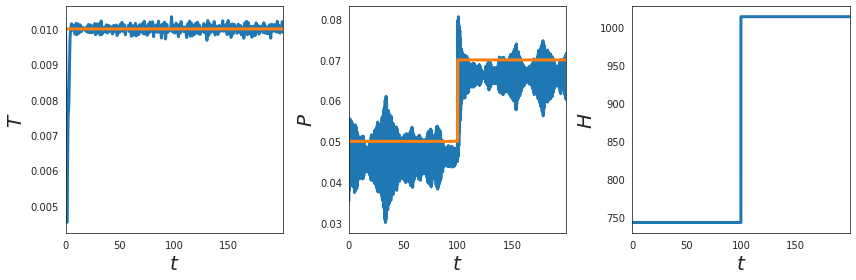

In [35]:
plt.subplot(1, 3, 1)

t = onp.arange(0, steps) * dt
plt.plot(t, log['kT'], linewidth=3)
plt.plot(t, kT * np.ones_like(t), linewidth=3)
plt.xlim([t[0], t[-1]])
format_plot('$t$', '$T$')

plt.subplot(1, 3, 2)

t = onp.arange(0, steps) * dt
plt.plot(t, log['P'], linewidth=3)
plt.plot(t, P(t), linewidth=3)
plt.xlim([t[0], t[-1]])
format_plot('$t$', '$P$')

plt.subplot(1, 3, 3)

t = onp.arange(0, steps) * dt
plt.plot(t, log['H'], linewidth=3)
plt.xlim([t[0], t[-1]])
format_plot('$t$', '$H$')

finalize_plot((2, 2 / 3))

Now let's plot a snapshot of the system.

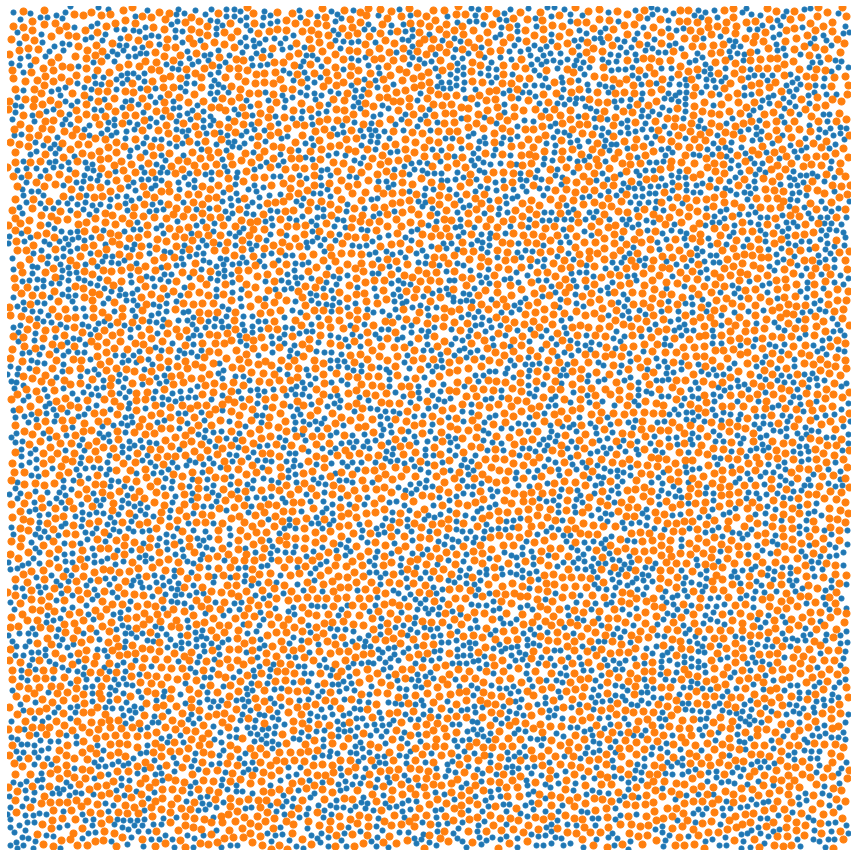

In [36]:
ms = 10
R_plt = onp.array(state.position)

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

If we want, we can also draw an animation of the simulation using JAX MD's renderer.

In [37]:
from jax_md.colab_tools import renderer

diameters = sigma[species, species]
colors = np.where(species[:, None], 
                  np.array([[1.0, 0.5, 0.01]]), 
                  np.array([[0.35, 0.65, 0.85]]))

renderer.render(box[0, 0],
                {
                    'particles': renderer.Disk(log['position'], 
                                               diameters,
                                               colors)
                },
                buffer_size=20,
                resolution=(700, 700))

Finally, let's plot the velocity distribution compared with its theoretical prediction.

In [21]:
V_flat = onp.reshape(onp.array(state.velocity), (-1,))
occ, bins = onp.histogram(V_flat, bins=100, normed=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


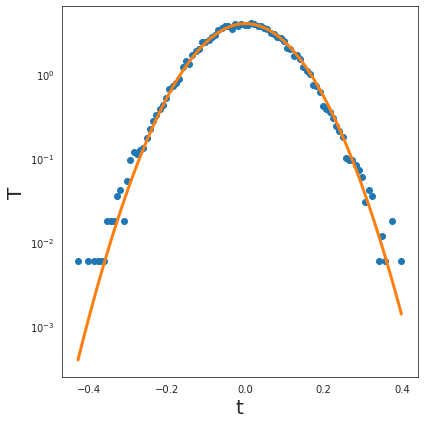

In [22]:
T_cur = kT
plt.semilogy(bins[:-1], occ, 'o')
plt.semilogy(
    bins[:-1], 
    1.0 / np.sqrt(2 * np.pi * T_cur) * onp.exp(-1/(2 * T_cur) * bins[:-1] ** 2), 
    linewidth=3)
format_plot('t', 'T')
finalize_plot()